# Data Science Capstone Project

## Segmenting the Crossfit Boxes in Budapest


### What is Crossfit?

Crossfit is a relatively new fitness direction, basically functional fitness where the goal is to prepare your body for any physical challenge. Originally, it started as a licensed brand, and it started spreading across the world later. It includes nearly every kind of sport, from the olympic wightlifting, through gymnastic skills, running, endurance tests etc. This sport is done in places called Boxes. These are not like regular gyms, they need special floor, special equipment, therefore this functional fitness cannot be done everywhere.

### Crossfit in Hungary, Budapest

Crossfit was established in Hungary in the early 2013 with only a few boxes. There is a difference between the original Crossfit Boxes and the other places, so called Cross-training gyms. The main difference is the name, therefore the brand that it represents. Only those boxes, who bought the license can use the name Crossfit. In this project, I only investigate the licensed boxes, because these are the traditional Crossfit Boxes

### Business Understanding

The main purpose of this project is to reveal the potential places in Budapest, Hungary where a Crossfit Box can be started. There are many neighborhood with the proper condition for establishing a Crossfit Box, some of them already have one. This investigation will reveal the common attributes between these, and also tries to find other, similar neighborhoods. 

The true questions is: Is it possible to predict the potential places for the new Crossfit Boxes based on only the location data?

This project will give answer for the question above for those who are thinking about establishing a Crossfit Box in Budapest.


### Methodology

To reach the goal, first and foremost, I needed a dataset, which contains the Budapest neighborhood coordinations. Thanks to the Geolocator API, there is no need for a dataset which contains them explicitly, I just need the proper names of the neighborhoods. With the following webpage: https://en.wikipedia.org/wiki/List_of_districts_in_Budapest and a little transormation on these is enough to fulfill this requirement. After these coordinations are claimed, the Foursquare API will give the data regarding the user feedback for each neighborhood.


After this, to check the pattern of the Crossfit Boxes attributions, firstly the name of the licensed Crossfit Boxes are needed, then the same logic will be applied as before.

From this point, the model can clearly decide which neighborhood is similar to a Crossfit Box and we can create recommendations regarding the position of the new one.

### Data analysis

First is to import every library that I will need for building the model.

In [26]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!pip install geopy==2.2.0
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!pip install folium
import folium # map rendering library

#!pip install pyproj
import pyproj

#pyplot
import matplotlib.pyplot as plt

print('Libraries imported.')

  Found existing installation: geopy 1.22.0
    Uninstalling geopy-1.22.0:
      Successfully uninstalled geopy-1.22.0
Libraries imported.


The following functions are needed for converting the lateral - longitudinal values into coordinates and vica-versa.

In [2]:
def xy_to_lonlat(x, y):
    proj_latlon = pyproj.Proj(proj='latlong',datum='WGS84')
    proj_xy = pyproj.Proj(proj="utm", zone=33, datum='WGS84')
    lonlat = pyproj.transform(proj_xy, proj_latlon, x, y)
    return lonlat[0], lonlat[1]

In [3]:
def lonlat_to_xy(lon, lat):
    proj_latlon = pyproj.Proj(proj='latlong',datum='WGS84')
    proj_xy = pyproj.Proj(proj="utm", zone=33, datum='WGS84')
    xy = pyproj.transform(proj_latlon, proj_xy, lon, lat)
    return xy[0], xy[1]

The next step is to load our main dataset, which contains the neighborhood names for Budapest, Hungary. The following page is used for that purpose: https://en.wikipedia.org/wiki/List_of_districts_in_Budapest
Also, for the different dataset manipulation operations, the pandas package of python will be the proper tool.

In [46]:
#parsing the dataset from url
url = 'https://en.wikipedia.org/wiki/List_of_districts_in_Budapest'

data = pd.read_html(url)
df = pd.DataFrame(data = data[0])
column_names = ["DistrictNumber","DistrictName","Neighborhoods","Sights"]
df.columns = column_names
df.drop(labels = 0, axis = 0, inplace = True)
df.drop(columns="Sights", inplace = True)
df

,DistrictNumber,DistrictName,Neighborhoods
1,I.,Várkerület(Castle District),"Buda Castle, Tabán, Gellérthegy, Krisztinaváro..."
2,II.,none,"Adyliget, Budakeszierdő, Budaliget, Csatárka, ..."
3,III.,Óbuda-Békásmegyer,"Óbuda, Aquincum, Aranyhegy, Békásmegyer, Csill..."
4,IV.,Újpest(New Pest),"Újpest, Megyer, Káposztásmegyer, Székesdűlő, I..."
5,V.,Belváros-Lipótváros(Inner City-Leopold Town),"Inner City, Lipótváros"
6,VI.,Terézváros(Theresa Town),Terézváros
7,VII.,Erzsébetváros(Elizabeth Town),Erzsébetváros
8,VIII.,Józsefváros(Joseph Town),"Józsefváros, Kerepesdűlő, Tisztviselőtelep"
9,IX.,Ferencváros(Francis Town),"Ferencváros, Gubacsidűlő, József Attila-lakótelep"
10,X.,Kőbánya(Quarry),"Felsőrákos, Gyárdűlő, Keresztúridűlő, Kőbánya-..."


This looks good, but I need the proper format for finding the Geo coordinates for each neighborhood, so I need some additional adjustments.

In [47]:
s = pd.DataFrame(df.Neighborhoods.str.split(",").tolist(), index=df.DistrictNumber).stack()
s

DistrictNumber    
I.              0                   Buda Castle
                1                         Tabán
                2                   Gellérthegy
                3                Krisztinaváros
                4            southern Víziváros
II.             0                      Adyliget
                1                 Budakeszierdő
                2                     Budaliget
                3                      Csatárka
                4                 Erzsébetliget
                5                 Erzsébettelek
                6                      Felhévíz
                7                        Gercse
                8                    Hársakalja
                9                      Hárshegy
                10                   Hűvösvölgy
                11                        Kővár
                12                     Kurucles
                13                    Lipótmező
                14                  Máriaremete
                15   

In [48]:
added_df = pd.DataFrame(columns=["DistrictNumber", "Neighborhood"])
added_df.Neighborhood = s.values
added_df.DistrictNumber = s.index.get_level_values("DistrictNumber")
added_df

,DistrictNumber,Neighborhood
0,I.,Buda Castle
1,I.,Tabán
2,I.,Gellérthegy
3,I.,Krisztinaváros
4,I.,southern Víziváros
5,II.,Adyliget
6,II.,Budakeszierdő
7,II.,Budaliget
8,II.,Csatárka
9,II.,Erzsébetliget


In case of inappropriate values for the geolocator, I need to drop and refill some of the records with proper format.

In [49]:
added_df.drop(axis=0, index=4, inplace=True) #dropping southern Víziváros I. in case of inappropriate value
added_df.drop(axis=0, index=110, inplace=True) #dropping Sashegy XII. in case of inappropriate value
added_df.drop(axis=0, index=104, inplace=True) #dropping Krisztinaváros XII. in case of inappropriate value
added_df.drop(axis=0, index=165, inplace=True) #dropping Margit-sziget in case of inappropriate value
added_df.drop(axis=0, index=96, inplace=True) #dropping Tabán XI. in case of inappropriate value
added_df.drop(axis=0, index=2, inplace=True) #dropping Gellérthegy I. in case of inappropriate value
added_df.drop(axis=0, index=53, inplace=True) #dropping Szépvölgy III. in case of inappropriate value
added_df.drop(axis=0, index=36, inplace=True) #dropping northern Víziváros II. in case of inappropriate value, replaced
added_df.drop(axis=0, index=25, inplace=True) #dropping Petneházy-rét II. in case of inappropriate value, replaced
added_df.drop(axis=0, index=34, inplace=True) #dropping Újlak II. in case of inappropriate value
added_df.drop(axis=0, index=58, inplace=True) #dropping Újlak III. in case of inappropriate value, replaced
added_df.drop(axis=0, index=64, inplace=True) #dropping Inner City V. in case of inappropriate value, replaced
added_df.drop(axis=0, index=139, inplace=True) #dropping Szentgyörgytelep XVI. in case of inappropriate value, replaced
added_df.drop(axis=0, index=141, inplace=True) #dropping Huszkatelep XVI. in case of inappropriate value
added_df.drop(axis=0, index=159, inplace=True) #dropping Pesterzsébet-Szabótelep XX. in case of inappropriate value, replaced
print("dropping finished")

dropping finished


In [50]:
added_df.reset_index(drop = True, inplace=True)
added_df

,DistrictNumber,Neighborhood
0,I.,Buda Castle
1,I.,Tabán
2,I.,Krisztinaváros
3,II.,Adyliget
4,II.,Budakeszierdő
5,II.,Budaliget
6,II.,Csatárka
7,II.,Erzsébetliget
8,II.,Erzsébettelek
9,II.,Felhévíz


In [51]:
# added_df.replace(to_replace='northern Víziváros', value='Víziváros', inplace=True) is not working due to an internal error, 
# therefore I had to use something else

# data of for replacing the inapproriate values, tested with Nominatim
vizivaros={"DistrictNumber":"II.", "Neighborhood":"Víziváros"}
petnehazyret={"DistrictNumber":"II.", "Neighborhood":"Petneházyrét"}
ujlak={"DistrictNumber":"III.", "Neighborhood":"Újlak"}
belvaros={"DistrictNumber":"V.", "Neighborhood":"Belváros"}
szentgyorgytelep ={"DistrictNumber":"XVI.", "Neighborhood":"Szent György telep"}
szabotelep ={"DistrictNumber":"XX.", "Neighborhood":"Szabótelep"}

added_df=added_df.append(vizivaros, ignore_index=True)
added_df=added_df.append(petnehazyret, ignore_index=True)
added_df=added_df.append(ujlak, ignore_index=True)
added_df=added_df.append(belvaros, ignore_index=True)
added_df=added_df.append(szentgyorgytelep, ignore_index=True)
added_df=added_df.append(szabotelep, ignore_index=True)
added_df

,DistrictNumber,Neighborhood
0,I.,Buda Castle
1,I.,Tabán
2,I.,Krisztinaváros
3,II.,Adyliget
4,II.,Budakeszierdő
5,II.,Budaliget
6,II.,Csatárka
7,II.,Erzsébetliget
8,II.,Erzsébettelek
9,II.,Felhévíz


At this point, we have the proper name for each neighborhood, the next step is to find the Geo locations (latitude and longitude values) for them. The following code is doing that perfectly, using Geopy python package.

In [53]:
addr_list = added_df.Neighborhood.to_list()
geolocator = Nominatim(user_agent="cf_explorer")

for i in range(len(addr_list)):
    location = geolocator.geocode(addr_list[i])
    latitude = location.latitude
    longitude = location.longitude
    print('The geolocator found the geolocations of: {}, latitude is: {} , and the longitude is: {}'.format(addr_list[i],
                                                                                                         latitude,
                                                                                                         longitude))

The geolocator found the geolocations of: Buda Castle, latitude is: 47.4959913 , and the longitude is: 19.03980079634199
The geolocator found the geolocations of:  Tabán, latitude is: 47.4908934 , and the longitude is: 19.0426394
The geolocator found the geolocations of:  Krisztinaváros, latitude is: 47.4968655 , and the longitude is: 19.0297756
The geolocator found the geolocations of: Adyliget, latitude is: 47.5475499 , and the longitude is: 18.9389837
The geolocator found the geolocations of:  Budakeszierdő, latitude is: 47.5102729 , and the longitude is: 18.9511817
The geolocator found the geolocations of:  Budaliget, latitude is: 47.5675791 , and the longitude is: 18.940664
The geolocator found the geolocations of:  Csatárka, latitude is: 47.5315247 , and the longitude is: 19.002578
The geolocator found the geolocations of:  Erzsébetliget, latitude is: 47.5617139 , and the longitude is: 18.9675585
The geolocator found the geolocations of:  Erzsébettelek, latitude is: 47.544978 , a

The geolocator found the geolocations of:  Gazdagrét, latitude is: 47.4701163 , and the longitude is: 18.9986749
The geolocator found the geolocations of:  Gellérthegy, latitude is: 47.4845654 , and the longitude is: 19.038769
The geolocator found the geolocations of:  Hosszúrét, latitude is: 47.4661016 , and the longitude is: 18.9973798
The geolocator found the geolocations of:  Kamaraerdő, latitude is: 47.4300656 , and the longitude is: 18.9869244
The geolocator found the geolocations of:  Kelenföld, latitude is: 47.4642992 , and the longitude is: 19.0206155
The geolocator found the geolocations of:  Kelenvölgy, latitude is: 47.4477776 , and the longitude is: 19.0243881
The geolocator found the geolocations of:  Kőérberek, latitude is: 47.4414771 , and the longitude is: 18.9958115
The geolocator found the geolocations of:  Lágymányos, latitude is: 47.4747554 , and the longitude is: 19.0555001
The geolocator found the geolocations of:  Madárhegy, latitude is: 47.4677382 , and the long

The geolocator found the geolocations of:  Pacsirtatelep, latitude is: 47.4244189 , and the longitude is: 19.1199827
The geolocator found the geolocations of:  Pesterzsébet, latitude is: 47.4333961 , and the longitude is: 19.1209209
The geolocator found the geolocations of: Csepel, latitude is: 47.424317 , and the longitude is: 19.06921381860224
The geolocator found the geolocations of: Budatétény, latitude is: 47.4171277 , and the longitude is: 19.0106567
The geolocator found the geolocations of:  Nagytétény, latitude is: 47.3975678 , and the longitude is: 18.9859582
The geolocator found the geolocations of:  Budafok, latitude is: 47.4275301 , and the longitude is: 19.0260778
The geolocator found the geolocations of: Soroksár, latitude is: 47.3894047 , and the longitude is: 19.1441576
The geolocator found the geolocations of: Víziváros, latitude is: 47.5071427 , and the longitude is: 19.0345173
The geolocator found the geolocations of: Petneházyrét, latitude is: 47.5372112 , and the l

In [54]:
addr_list = added_df.Neighborhood.to_list()
district_list = added_df.DistrictNumber.to_list()
lat_list = []
lon_list = []

geolocator = Nominatim(user_agent="cf_explorer")

for actual_address in range(len(addr_list)):
    location = geolocator.geocode(addr_list[actual_address])
    latitude = location.latitude
    longitude = location.longitude
    lat_list.append(latitude)
    lon_list.append(longitude)

added_df["Latitude"] = lat_list
added_df["Longitude"] = lon_list
added_df

,DistrictNumber,Neighborhood,Latitude,Longitude
0,I.,Buda Castle,47.495991,19.039801
1,I.,Tabán,47.490893,19.042639
2,I.,Krisztinaváros,47.496865,19.029776
3,II.,Adyliget,47.547550,18.938984
4,II.,Budakeszierdő,47.510273,18.951182
5,II.,Budaliget,47.567579,18.940664
6,II.,Csatárka,47.531525,19.002578
7,II.,Erzsébetliget,47.561714,18.967558
8,II.,Erzsébettelek,47.544978,18.957372
9,II.,Felhévíz,47.517500,19.037039


Now, we have all the proper names, latitude and longitude values for each neighborhood in Budapest, Hungary. The next step is to first, check the coordinates of Budapest with the geolocator class object, and then, we can create a map, to visualize our insights later.

In [55]:
#Checking the coordinates of Budapest, Hungary for creating a map
name_bud = "Budapest, Hungary"

location_bud = geolocator.geocode(name_bud)
lat_bud = location_bud.latitude
lon_bud = location_bud.longitude

print('The geograpical coordinate of Budapest are {}, {}.'.format(lat_bud, lon_bud))
print('Coordinate transformation check')
print('-------------------------------')
print('Budapest center longitude={}, latitude={}'.format(lon_bud, lat_bud))
x, y = lonlat_to_xy(lon_bud, lat_bud)
print('Budapest center UTM X={}, Y={}'.format(x, y))
lo, la = xy_to_lonlat(x, y)
print('Budapest center longitude={}, latitude={}'.format(lo, la))

The geograpical coordinate of Budapest are 47.4979937, 19.0403594.
Coordinate transformation check
-------------------------------
Budapest center longitude=19.0403594, latitude=47.4979937
Budapest center UTM X=804283.1088846511, Y=5268422.807057823
Budapest center longitude=19.0403594, latitude=47.49799370000001


F:\Programs\Anaconda\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  after removing the cwd from sys.path.
F:\Programs\Anaconda\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  after removing the cwd from sys.path.


In [56]:
# create map of Manhattan using latitude and longitude values
map_budapest = folium.Map(location=[lat_bud, lon_bud], zoom_start=11)

# add markers to map
for lat, lng, label in zip(added_df['Latitude'], added_df['Longitude'], added_df['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_budapest)  
    
map_budapest

Next step is to create the dataset for the Crossfit Boxes of Budapest. Since there is no available data, I needed to create my own.

In [57]:
#I had to create my own dataset for the Crossfit boxes in Budapest, because there was no accessable table regarding this
cf_list_bud = ["Crossfit Budapest", "Reebok Crossfit Duna", "Crossfit Tesseract", "Crossfit Everybody", 
               "Crossfit Mayfly", "Crossfit BBros", "Crossfit BBros 2", "Crossfit Grund", "Crossfit Bloodfit", 
              "Crossfit Glasshouse", "Crossfit Újbuda", "Bulls Park Crossfit", "Crossfit Corvinus"]
cf_bud_addr = ["Pillangó Park 8", "Hajógyári sziget 130", "Mexikói út 25", "Borszék köz 1", 
               "Kondorfa utca 6", "Zichy Géza utca 12", "Márton utca 4", "Hegedűs Gyula utca 14", "Tüzér utca 46",
              "Nándorfejérvári út 40", "Barázda utca 1", "Sopron út 9", "Gyömrői út 118"]
cf_bud_distr = ["XIV.", "III.", "XIV.", "XI.", "XI.", "XIV.", "IX.", "XIII.", "XIII.", "XI.", "XI.", "XI.", "XVIII"]
cf_df_col_list = ["DistrictNumber", "CrossfitBoxName", "Address", "Latitude", "Longitude"]
cf_df = pd.DataFrame(columns = cf_df_col_list)
cf_df.DistrictNumber = cf_bud_distr
cf_df.CrossfitBoxName = cf_list_bud
cf_df.Address = cf_bud_addr
cf_df

,DistrictNumber,CrossfitBoxName,Address,Latitude,Longitude
0,XIV.,Crossfit Budapest,Pillangó Park 8,NaN,NaN
1,III.,Reebok Crossfit Duna,Hajógyári sziget 130,NaN,NaN
2,XIV.,Crossfit Tesseract,Mexikói út 25,NaN,NaN
3,XI.,Crossfit Everybody,Borszék köz 1,NaN,NaN
4,XI.,Crossfit Mayfly,Kondorfa utca 6,NaN,NaN
5,XIV.,Crossfit BBros,Zichy Géza utca 12,NaN,NaN
6,IX.,Crossfit BBros 2,Márton utca 4,NaN,NaN
7,XIII.,Crossfit Grund,Hegedűs Gyula utca 14,NaN,NaN
8,XIII.,Crossfit Bloodfit,Tüzér utca 46,NaN,NaN
9,XI.,Crossfit Glasshouse,Nándorfejérvári út 40,NaN,NaN


In [58]:
cf_bud_district = ["XIV.", "III.", "XIV.", "XI.", "XI.", "XIV.", "IX.", "XIII.", "XIII.", "XI.", "XI.", "XI.", "XVIII"]
cf_bud_address = ["Pillangó Park 8", "Hajógyári sziget 130", "Mexikói út 25", "Borszék köz 1", 
               "Kondorfa utca 6", "Zichy Géza utca 12", "Márton utca 4", "Hegedűs Gyula utca 14", "Tüzér utca 46",
              "Nándorfejérvári út 40", "Barázda utca 1", "Sopron út 9", "Gyömrői út 118"]

cf_lat_list = []
cf_lon_list = []
cf_loc = []

for actual_address in range(len(cf_bud_address)):
     cf_loc.append("{}, Budapest, Hungary".format(cf_bud_address[actual_address]))
    
geolocator = Nominatim(user_agent="hun_explorer")

for actual_address in range(len(cf_loc)):
    location = geolocator.geocode(cf_loc[actual_address])
    latitude = location.latitude
    longitude = location.longitude
    cf_lat_list.append(latitude)
    cf_lon_list.append(longitude)
    
    

cf_df["Latitude"] = cf_lat_list
cf_df["Longitude"] = cf_lon_list
cf_df

,DistrictNumber,CrossfitBoxName,Address,Latitude,Longitude
0,XIV.,Crossfit Budapest,Pillangó Park 8,47.505122,19.121754
1,III.,Reebok Crossfit Duna,Hajógyári sziget 130,47.554403,19.059319
2,XIV.,Crossfit Tesseract,Mexikói út 25,47.519416,19.090593
3,XI.,Crossfit Everybody,Borszék köz 1,47.458482,19.026134
4,XI.,Crossfit Mayfly,Kondorfa utca 6,47.453356,19.043747
5,XIV.,Crossfit BBros,Zichy Géza utca 12,47.509135,19.092250
6,IX.,Crossfit BBros 2,Márton utca 4,47.476906,19.077625
7,XIII.,Crossfit Grund,Hegedűs Gyula utca 14,47.514103,19.053601
8,XIII.,Crossfit Bloodfit,Tüzér utca 46,47.524592,19.070284
9,XI.,Crossfit Glasshouse,Nándorfejérvári út 40,47.461456,19.045858


Adding the Crossfit Boxes into our previoulsy created map, to see their position.

In [59]:
# add markers to map
for lat, lng, label in zip(cf_df['Latitude'], cf_df['Longitude'], cf_df['CrossfitBoxName']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_budapest)
    folium.Circle([lat, lng], radius=500, color='white', fill=False).add_to(map_budapest) 
    
map_budapest

Now, we see that there are plenty of Crossfit Boxes among Budapest city, also they trying to follow a pattern. Each Box tries to be as close to the inner town as they can, also they tries to position themselves in the crowded areas. To fully understand their behavior and segment the neighborhoods, we need to create one final dataset.

Concatenating these two separate datasets into one greater will create our final dataset.

In [60]:
#Concat the two venue list to see how the clustering performs then
bp_df = added_df
bud_cf_df = cf_df
bud_cf_df.rename(columns={'CrossfitBoxName':'Neighborhood'}, inplace=True)
bud_cf_df.drop(labels='Address',axis=1, inplace=True)
total_df = pd.concat([bp_df,bud_cf_df], ignore_index=True)
total_df

,DistrictNumber,Neighborhood,Latitude,Longitude
0,I.,Buda Castle,47.495991,19.039801
1,I.,Tabán,47.490893,19.042639
2,I.,Krisztinaváros,47.496865,19.029776
3,II.,Adyliget,47.547550,18.938984
4,II.,Budakeszierdő,47.510273,18.951182
5,II.,Budaliget,47.567579,18.940664
6,II.,Csatárka,47.531525,19.002578
7,II.,Erzsébetliget,47.561714,18.967558
8,II.,Erzsébettelek,47.544978,18.957372
9,II.,Felhévíz,47.517500,19.037039


Visualizing the dataset will give us some insights. First of all, we can see exactly where these neighborhoods are, therefore we can check their population distribution among the city.

In [61]:
# create map of Budapest using latitude and longitude values
map_budapest = folium.Map(location=[lat_bud, lon_bud], zoom_start=11)

# add markers to map
for lat, lng, label in zip(total_df['Latitude'], total_df['Longitude'], total_df['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_budapest)  
    
map_budapest

Every preparation has made to start working on the model feed data. I used Foursquare data to create different clusters for the neighborhoods based on the user feedbacks on them. 

First, I need the nearby venues, then to make them into the proper format. After that I get the most common venues and then create a dataframe for them.

In [62]:
CLIENT_ID = '0MFCFREMOK4AFUKGFNYWNXCOUYXBAV42GI5EBWJD0MHGQWLB' # your Foursquare ID
CLIENT_SECRET = 'PK0OAQYGL2DVPJADSJR2IP5VRIUNBFM1AX3NRDYGPCL3B5LA' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

total_data = total_df
LIMIT = 500
total_bp_venues = getNearbyVenues(names=total_data['Neighborhood'],
                                   latitudes=total_data['Latitude'],
                                   longitudes=total_data['Longitude']
                                  )

print(total_bp_venues.shape)
total_bp_venues.head()

total_bp_venues.groupby('Neighborhood').count()
print('There are {} uniques categories.'.format(len(total_bp_venues['Venue Category'].unique())))

Your credentails:
CLIENT_ID: 0MFCFREMOK4AFUKGFNYWNXCOUYXBAV42GI5EBWJD0MHGQWLB
CLIENT_SECRET:PK0OAQYGL2DVPJADSJR2IP5VRIUNBFM1AX3NRDYGPCL3B5LA
Buda Castle
 Tabán
 Krisztinaváros
Adyliget
 Budakeszierdő
 Budaliget
 Csatárka
 Erzsébetliget
 Erzsébettelek
 Felhévíz
 Gercse
 Hársakalja
 Hárshegy
 Hűvösvölgy
 Kővár
 Kurucles
 Lipótmező
 Máriaremete
 Nyék
 Országút
 Pálvölgy
 Pasarét
 Pesthidegkút-Ófalu
 Remetekertváros
 Rézmál
 Rózsadomb
 Szemlőhegy
 Széphalom
 Szépilona
 Szépvölgy
 Törökvész
 Vérhalom
 Zöldmál.
Óbuda
 Aquincum
 Aranyhegy
 Békásmegyer
 Csillaghegy
 Csúcshegy
 Filatorigát
 Hármashatár-hegy
 Kaszásdűlő
 Mátyáshegy
 Mocsárosdűlő
 Óbudai-sziget
 Remetehegy
 Rómaifürdő
 Solymárvölgy
 Táborhegy
 Testvérhegy
 Törökkő
 Ürömhegy
Újpest
 Megyer
 Káposztásmegyer
 Székesdűlő
 Istvántelek.
 Lipótváros
Terézváros
Erzsébetváros
Józsefváros
 Kerepesdűlő
 Tisztviselőtelep
Ferencváros
 Gubacsidűlő
 József Attila-lakótelep
Felsőrákos
 Gyárdűlő
 Keresztúridűlő
 Kőbánya-Kertváros
Albertfalva
 Dob

In [63]:
# one hot encoding
total_bp_onehot = pd.get_dummies(total_bp_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
total_bp_onehot['Neighborhood'] = total_bp_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [total_bp_onehot.columns[-1]] + list(total_bp_onehot.columns[:-1])
total_bp_onehot = total_bp_onehot[fixed_columns]

total_bp_grouped = total_bp_onehot.groupby('Neighborhood').mean().reset_index()

num_top_venues = 5

for hood in total_bp_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = total_bp_grouped[total_bp_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

---- Akadémiaújtelep----
                  venue  freq
0                Bakery  0.25
1  Fast Food Restaurant  0.25
2              Pharmacy  0.25
3                  Park  0.25
4           Yoga Studio  0.00


---- Angyalföld----
                   venue  freq
0                    Gym  0.25
1     Light Rail Station  0.25
2           Tram Station  0.25
3                 Bistro  0.25
4  Outdoors & Recreation  0.00


---- Aquincum----
           venue  freq
0  Historic Site  0.20
1         Bakery  0.13
2       Pharmacy  0.07
3          Plaza  0.07
4  Grocery Store  0.07


---- Budafok----
           venue  freq
0       Bus Stop  0.33
1     Playground  0.17
2  Grocery Store  0.17
3           Park  0.17
4    Supermarket  0.17


---- Budakeszierdő----
              venue  freq
0     Historic Site   1.0
1       Yoga Studio   0.0
2      Perfume Shop   0.0
3  Pedestrian Plaza   0.0
4       Pastry Shop   0.0


---- Budaliget----
               venue  freq
0           Bus Stop  0.50
1               

4        Pastry Shop   0.0


---- Magasút----
            venue  freq
0     Bus Station  0.12
1          Forest  0.12
2             Gym  0.12
3    Gourmet Shop  0.12
4  Scenic Lookout  0.12


---- Megyer----
               venue  freq
0                Gym   0.5
1          Gastropub   0.5
2        Yoga Studio   0.0
3  Outdoor Sculpture   0.0
4        Pastry Shop   0.0


---- Mocsárosdűlő----
               venue  freq
0         Playground  0.25
1          Racetrack  0.25
2              Field  0.25
3           Heliport  0.25
4  Outdoor Sculpture  0.00


---- Máriaremete----
                  venue  freq
0              Bus Stop   0.3
1        Farmers Market   0.1
2    Italian Restaurant   0.1
3        Ice Cream Shop   0.1
4  Hungarian Restaurant   0.1


---- Mártonhegy----
            venue  freq
0        Bus Stop  0.24
1      Playground  0.18
2           Plaza  0.06
3    Tennis Court  0.06
4  Farmers Market  0.06


---- Mátyáshegy----
                venue  freq
0                Cave   0

                     venue  freq
0            Grocery Store  0.09
1     Gym / Fitness Center  0.07
2                 Bus Stop  0.07
3              Coffee Shop  0.07
4  Health & Beauty Service  0.04


---- Vérhalom----
                       venue  freq
0                    Dog Run  0.12
1                  Wine Shop  0.06
2                     Bakery  0.06
3  Middle Eastern Restaurant  0.06
4                       Park  0.06


---- Wekerletelep----
       venue  freq
0   Bus Stop  0.16
1       Park  0.16
2       Café  0.08
3  Wine Shop  0.04
4   Pharmacy  0.04


---- Zöldmál.----
                 venue  freq
0             Bus Stop   0.5
1            Wine Shop   0.1
2  Japanese Restaurant   0.1
3          Snack Place   0.1
4          Pizza Place   0.1


---- Árpádföld----
               venue  freq
0           Bus Stop  0.29
1         Restaurant  0.14
2      Grocery Store  0.07
3  Food & Drink Shop  0.07
4               Park  0.07


---- Óbudai-sziget----
               venue  freq
0    

In [64]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted_total_bp = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted_total_bp['Neighborhood'] = total_bp_grouped['Neighborhood']

for ind in np.arange(total_bp_grouped.shape[0]):
    neighborhoods_venues_sorted_total_bp.iloc[ind, 1:] = return_most_common_venues(total_bp_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted_total_bp.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Akadémiaújtelep,Bakery,Park,Fast Food Restaurant,Pharmacy,Falafel Restaurant,Farm,Farmers Market,Field,Fish & Chips Shop,Wine Shop
1,Angyalföld,Light Rail Station,Bistro,Tram Station,Gym,Fish & Chips Shop,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field
2,Aquincum,Historic Site,Bakery,Karaoke Bar,Greek Restaurant,Light Rail Station,Bar,Grocery Store,Gym,Train Station,Pharmacy
3,Budafok,Bus Stop,Grocery Store,Playground,Supermarket,Park,Fish Market,Farm,Farmers Market,Fast Food Restaurant,Field
4,Budakeszierdő,Historic Site,Wine Shop,Fabric Shop,Farm,Farmers Market,Fast Food Restaurant,Field,Fish & Chips Shop,Fish Market,Flea Market


For the record, it can give a good insight if I check the population distribution among the 1st most common venue. As the result shows, the most common venues are the bus stops, grocery stores and playgrounds.

In [93]:
neighborhoods_venues_sorted_total_bp['1st Most Common Venue'].value_counts()

Bus Stop                       47
Grocery Store                  11
Playground                      7
Park                            5
Scenic Lookout                  5
Bakery                          5
Hungarian Restaurant            4
Coffee Shop                     4
Pub                             3
Dog Run                         3
Diner                           3
Historic Site                   3
Bar                             3
Fast Food Restaurant            2
Electronics Store               2
Gym                             2
Cave                            2
Mountain                        2
Restaurant                      2
Athletics & Sports              2
Café                            2
Baseball Stadium                1
Deli / Bodega                   1
Forest                          1
Vineyard                        1
Eastern European Restaurant     1
Sports Club                     1
Tennis Court                    1
Buffet                          1
Stadium       

Once the most common venues dataset is available for the Budapest neighborhoods and Crossfit Boxes, all the preparations has been made to start creating the clustering model.

### Modelling

To segment the different neighborhoods into different categories, I used KMeans clustering. This algorythm is highly iterative which means the first round won't be the sufficient one due to its nature. Therefore I created a loop, which increments through different values os K and then evaluate each iteration. At the final stage, it visualize the different stages of the loop to help in the seletion of the proper value of K.

The segmentation will be a KMeans clustering model which can create different clusters for the similar objects in the dataset. For this, I used KMeans class object from the scikit-learn python package.

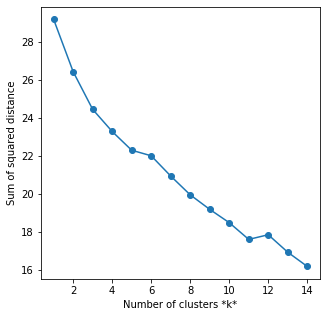

In [94]:
# Run the Kmeans algorithm and get the index of data points clusters
total_bp_clustering = total_bp_grouped.drop('Neighborhood', 1)
sse = []
list_k = list(range(1, 15))

for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(total_bp_clustering)
    sse.append(km.inertia_)

# Plot sse against k
plt.figure(figsize=(5, 5))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance');

As the plot presents, it decreases in a high volume, but it stops this trend around k = 11. Therefore, for the model, the proper number will be 11.

In [66]:
total_bp_clustering = total_bp_grouped.drop('Neighborhood', 1)

# set number of clusters
total_bp_clusters = 11

# run k-means clustering
total_bp_kmeans = KMeans(n_clusters=total_bp_clusters, random_state=0).fit(total_bp_clustering)

# check cluster labels generated for each row in the dataframe
total_bp_kmeans.labels_[0:10]

array([0, 9, 0, 1, 3, 7, 0, 7, 0, 0])

In [75]:
# add clustering labels
neighborhoods_venues_sorted_total_bp.insert(0, 'Cluster Labels', total_bp_kmeans.labels_)

total_bp_merged = total_df

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
total_bp_merged = total_bp_merged.join(neighborhoods_venues_sorted_total_bp.set_index('Neighborhood'), on='Neighborhood')
total_bp_merged["Cluster Labels"] = total_bp_merged["Cluster Labels"].fillna(0.0).astype(int)
#cf_bp_merged.head() # check the last columns!
neighborhoods_venues_sorted_total_bp.head()

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,0,Akadémiaújtelep,Bakery,Park,Fast Food Restaurant,Pharmacy,Falafel Restaurant,Farm,Farmers Market,Field,Fish & Chips Shop,Wine Shop
1,9,Angyalföld,Light Rail Station,Bistro,Tram Station,Gym,Fish & Chips Shop,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field
2,0,Aquincum,Historic Site,Bakery,Karaoke Bar,Greek Restaurant,Light Rail Station,Bar,Grocery Store,Gym,Train Station,Pharmacy
3,1,Budafok,Bus Stop,Grocery Store,Playground,Supermarket,Park,Fish Market,Farm,Farmers Market,Fast Food Restaurant,Field
4,3,Budakeszierdő,Historic Site,Wine Shop,Fabric Shop,Farm,Farmers Market,Fast Food Restaurant,Field,Fish & Chips Shop,Fish Market,Flea Market


Checking the population distribution of the different clusters.

In [92]:
neighborhoods_venues_sorted_total_bp['Cluster Labels'].value_counts()

2     55
1     42
0     23
7     16
10    13
6      6
9      3
3      2
8      1
5      1
4      1
Name: Cluster Labels, dtype: int64

It is not so bad, there are only 3 clusters which has only 1 member. These can be handled as outliers.

In [76]:
# create map
total_bp_map_clusters = folium.Map(location=[lat_bud, lon_bud], zoom_start=11)

# set color scheme for the clusters
x = np.arange(total_bp_clusters)
ys = [i + x + (i*x)**2 for i in range(total_bp_clusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(total_bp_merged['Latitude'], total_bp_merged['Longitude'], total_bp_merged['Neighborhood'], total_bp_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(total_bp_map_clusters)

       
total_bp_map_clusters

From this map, let's highlight each Crossfit Box.

In [80]:
for lat, lng, label in zip(cf_df['Latitude'], cf_df['Longitude'], cf_df['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.Circle([lat, lng], radius=500, color='white', fill=False).add_to(total_bp_map_clusters)

total_bp_map_clusters

The following result represents that which neighborhood has the same attributes as the different Crossfit boxes based on the Foursquare data. Obviously, this is not a full recommendation regarding the location of the perfect Crossfit Box in Budapest, but a good starting point.
Most of the Crossfit Boxes belongs to the dark blue class (cluster 2) which means that the dark blue color shows the best matchings. Also, you can find some purple (cluster 1) and red (cluster 0) markings too.

So lets check the potential good neighborhoods to establish a Crossfit Box.

In [89]:
cluster_1_df = neighborhoods_venues_sorted_total_bp[neighborhoods_venues_sorted_total_bp['Cluster Labels'] == 2].copy()
cluster_1_df.reset_index(inplace=True)
# There are 10 Crossfit Box in this list, they must be removed from the total number!
cluster_1_df_withoutcf = cluster_1_df.copy()
cluster_1_df_withoutcf.drop(axis=0, index=38, inplace=True) #dropping Bullspark Crossfit
cluster_1_df_withoutcf.drop(axis=0, index=39, inplace=True) #dropping Crossfit BBros 2
cluster_1_df_withoutcf.drop(axis=0, index=40, inplace=True) #dropping Crossfit Bloodfit
cluster_1_df_withoutcf.drop(axis=0, index=41, inplace=True) #dropping Crossfit Budapest
cluster_1_df_withoutcf.drop(axis=0, index=42, inplace=True) #dropping Crossfit Glasshouse
cluster_1_df_withoutcf.drop(axis=0, index=43, inplace=True) #dropping Crossfit Grund
cluster_1_df_withoutcf.drop(axis=0, index=44, inplace=True) #dropping Crossfit Mayfly
cluster_1_df_withoutcf.drop(axis=0, index=45, inplace=True) #dropping Crossfit Tesseract
cluster_1_df_withoutcf.drop(axis=0, index=46, inplace=True) #dropping Crossfit Ujbuda
cluster_1_df_withoutcf.drop(axis=0, index=49, inplace=True) #dropping Crossfit Duna
cluster_1_df_withoutcf.reset_index(inplace=True)
cnt_pot_cf_neighborhood = cluster_1_df_withoutcf['Neighborhood'].count()
print('The number of neighborhoods, which can be a good place for a Crossfit Box: {}'.format(cnt_pot_cf_neighborhood))
print('They are the following: {}'.format(cluster_1_df_withoutcf['Neighborhood'].values))

The number of neighborhoods, which can be a good place for a Crossfit Box: 45
They are the following: [' Csillaghegy' ' Felhévíz' ' Filatorigát' ' Gubacsidűlő' ' Gyárdűlő'
 ' Göncz Árpád városközpont' ' Herminamező' ' Hűvösvölgy' ' Istvánmező'
 ' Kaszásdűlő' ' Kerepesdűlő' ' Kiszugló' ' Káposztásmegyer' ' Lipótmező'
 ' Lipótváros' ' Lágymányos' ' Nagytétény' ' Nagyzugló' ' Németvölgy'
 ' Népsziget' ' Országút' ' Pestszentimre' ' Pösingermajor'
 ' Remetekertváros' ' Rákoscsaba-Újtelep' ' Régiakadémiatelep'
 ' Solymárvölgy' ' Szabadságtelep' ' Szépvölgy' ' Tabán' ' Táborhegy'
 ' Törökőr' ' Vizafogó' ' Óbudai-sziget' ' Őrmező' 'Albertfalva'
 'Belváros' 'Buda Castle' 'Erzsébetváros' 'Ferencváros' 'Rákospalota'
 'Terézváros' 'Óbuda' 'Újlak' 'Újlipótváros']


You can see above the list of the neighborhoods which can be a good place to start a Crossfit Box, based on Foursquare data.

### Summary

The question for the business is: Is it possible to predict the potential places for the new Crossfit Boxes based on only the location data?
Using the customer feedbacks of Foursquare, it is possible to find patterns
In Budapest there are 164 neighborhoods and 12 Crossfit Box, the purpose is to find common attributes among them
The population distribution is very divers among the city, but based on the visualization, most of the Crossfit Boxes are trying to be as close to the crowded areas as they can, like the inner city
To find the patterns I used an unsupervised learning technique, namely Kmeans clustering
Because of the nature of the algorithm, I have to run it iteratively with different value for K to firstly find the proper value for that
It turned out that for this dataset, the proper value for K is 11
After the clustering process, there are 3 clusters which contains at least 1 Crossfit Box, but most of them belongs to the 2nd cluster
In the 2nd cluster, there are 45 neighborhoods which means there are 45 potentially good places to start a Crossfit Box
Some neighborhoods are already close to a box, so the suggestion is to select a neighborhood which is relatively far away from a box, but belongs to this cluster, for instance: Belváros, Kerepesdűlő, Tabán

Using the geolocations of the neighborhoods of Budapest, the question of which can be a potentially good place to start a Crossfit Box is answered. Below you can see the list of the neighborhoods.

In [90]:
for i in range(len(cluster_1_df_withoutcf['Neighborhood'])):
    print(str(cluster_1_df_withoutcf.Neighborhood[i]))

 Csillaghegy
 Felhévíz
 Filatorigát
 Gubacsidűlő
 Gyárdűlő
 Göncz Árpád városközpont
 Herminamező
 Hűvösvölgy
 Istvánmező
 Kaszásdűlő
 Kerepesdűlő
 Kiszugló
 Káposztásmegyer
 Lipótmező
 Lipótváros
 Lágymányos
 Nagytétény
 Nagyzugló
 Németvölgy
 Népsziget
 Országút
 Pestszentimre
 Pösingermajor
 Remetekertváros
 Rákoscsaba-Újtelep
 Régiakadémiatelep
 Solymárvölgy
 Szabadságtelep
 Szépvölgy
 Tabán
 Táborhegy
 Törökőr
 Vizafogó
 Óbudai-sziget
 Őrmező
Albertfalva
Belváros
Buda Castle
Erzsébetváros
Ferencváros
Rákospalota
Terézváros
Óbuda
Újlak
Újlipótváros


There are overall 45. Some of them is already close to a Crossfit Box, so I strongly recommend to avoid them. The rest of the set can be a good start.